# Загрузка и первичный осмотр данных

In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')

In [238]:
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [239]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

# Функции для обработки данных

In [240]:
# заполнение пустых ячеек столбцов
def replace_empty_values(column: pd.Series):
    column.replace("", np.nan, inplace=True)

In [241]:
# подсчитываем статистические данные, которые дополняют картину при анализе графиков: 1-ый и 3-ий квартили, границы выбросов
def main_stat(column: pd.Series):
    perc25 = column.quantile(0.25)
    perc75 = column.quantile(0.75)
    IQR = perc75 - perc25
    print(f' 1-ый квартиль: {perc25}, 3-ий квартиль: {perc75}, IQR: {IQR}. Границы выбросов: [{perc25 - 1.5*IQR}, {perc75 + 1.5*IQR}]')

In [242]:
# находим статистически значимые различия
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'], 
                        students.loc[students.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для столбца', column)
            break

# Предобработка данных

In [243]:
# гипотеза: столбцы "studytime" и "studytime, granular" полностью скоррелированы 
print(students.studytime.corr(students['studytime, granular']))

-0.9999999999999991


In [244]:
# удалим лишний столбец
students.drop(['studytime, granular'], inplace=True, axis=1)


In [245]:
# удалим пустые ячейки в столбце score: вряд ли понадобятся для обучения модели
students.dropna(axis=0, how="any", subset=["score"], inplace=True)

In [246]:
# заполним пустые ячейки столбцов
for column in students.columns:
    replace_empty_values(column=students[column])

In [247]:
# переименуем столбцы датасета для удобства
new_columns_names = {
    'famsize'    : 'family_size',
    'Pstatus'    : 'parents_marriage_status',
    'Medu'       : 'mother_education',
    'Fedu'       : 'father_education',
    'Mjob'       : 'mother_job',
    'Fjob'       : 'father_job',
    'reason'     : 'school_choice_reason',
    'traveltime' : 'travel_time',
    'failures'   : 'non_study_failures',
    'studytime'  : 'study_time',
    'schoolsup'  : 'school_educational_support',
    'famsup'     : 'family_educational_support',
    'paid'       : 'maths_tutor',
    'activities' : 'extra_activities',
    'higher'     : 'want_higher_education',
    'famrel'     : 'family_relations',
    
}

students.rename(columns=new_columns_names, inplace=True)

# Анализ данных

## school - аббревиатура школы, в которой учится ученик

In [248]:
display(pd.DataFrame(students.school.value_counts(dropna=False, normalize=True)))

,school
GP,0.884319
MS,0.115681


Как видим, в данном столбце пропусков нет.

## sex - пол ученика ('F' - женский, 'M' - мужской)

In [249]:
display(pd.DataFrame(students.sex.value_counts(dropna=False, normalize=True)))

,sex
F,0.524422
M,0.475578


Снова нет пропусков, идем дальше.

## age - возраст ученика (от 15 до 22)

In [250]:
display(pd.DataFrame(students.age.value_counts(dropna=False, normalize=True)))

,age
16,0.264781
17,0.251928
15,0.210797
18,0.205656
19,0.053985
20,0.007712
22,0.002571
21,0.002571


Пропусков снова нет. Проверим на наличие выбросов:

 1-ый квартиль: 16.0, 3-ий квартиль: 18.0, IQR: 2.0. Границы выбросов: [13.0, 21.0]


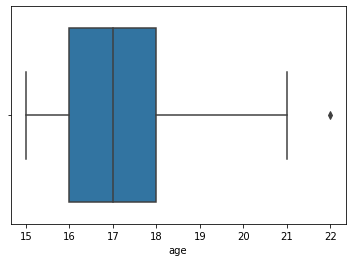

In [251]:
sns.boxplot('age',  data = students)
main_stat(students.age)

Хотя формально выбросом является только значение 22, здравый смысл говорит, что возраст школьников > 18 уже вызывает подозрение. Если возраст 19 лет еще допустим (ребенок мог пойти в школу в 8 лет или остаться на 2-ой год), то возраст 20 лет и более выглядит совсем неправдоподобным. Судя по тому, что таких учеников очень мало, вряд ли речь идет о стране,  где обучение длится более 11 лет. Возможно, это дети, имеющие заболевания, препятствующие нормальному умственному развитию, или особо "трудные" подростки, которым в принципе нужен индивидуальный подход к обучению. Не будем учитывать их в общей статистике:

In [252]:
students = students.loc[students.age <= 19]

## address - тип адреса ученика ('U' - городской, 'R' - за городом)

In [253]:
display(pd.DataFrame(students.address.value_counts(dropna=False, normalize=True)))

,address
U,0.750000
R,0.213542
NaN,0.036458


Около 4% данных в столбце пропущены. Гипотеза: можно предположить, что школьники, живущие за городом, добираются на учебу долго(> 30 мин), и за счет этого заполнить пропуски.

In [254]:
print(students.address[students.travel_time >= 3].value_counts(dropna=False))

R    16
U    12
Name: address, dtype: int64


In [255]:
print(students.address[students.travel_time <= 2].value_counts(dropna=False))

U      258
R       59
NaN     11
Name: address, dtype: int64


Как видим, гипотеза не подтвердилась: есть школьники, которые живут за городом, а добираются до школы быстро, причем таких большинство по отношению к общему количеству живущих за городом. При этом среди живущих в городе тоже есть те, кто добирапется долго. Возможно, школа расположена где-то на окраине

## family_size — размер семьи('LE3' <= 3, 'GT3' >3)

In [256]:
display(pd.DataFrame(students.family_size.value_counts(dropna=False, normalize=True)))

,family_size
GT3,0.653646
LE3,0.276042
NaN,0.070312


Около 7% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

##  parents_marriage_status — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [257]:
display(pd.DataFrame(students.parents_marriage_status.value_counts(dropna=False, normalize=True)))

,parents_marriage_status
T,0.794271
NaN,0.117188
A,0.088542


Около 12% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

## mother_education — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [258]:
display(pd.DataFrame(students.mother_education.value_counts(dropna=False, normalize=True)))

,mother_education
4.0,0.338542
2.0,0.257812
3.0,0.244792
1.0,0.143229
0.0,0.007812
NaN,0.007812


Менее 1% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Проверим на наличие выбросов:

 1-ый квартиль: 2.0, 3-ий квартиль: 4.0, IQR: 2.0. Границы выбросов: [-1.0, 7.0]


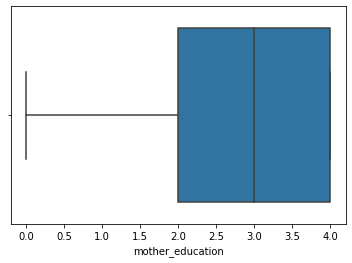

In [259]:
sns.boxplot('mother_education',  data = students)
main_stat(students.mother_education)

Выбросов здесь не наблюдается.

## father_education — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [260]:
display(pd.DataFrame(students.father_education.value_counts(dropna=False, normalize=True)))

,father_education
2.0,0.265625
3.0,0.244792
4.0,0.229167
1.0,0.190104
NaN,0.062500
0.0,0.005208
40.0,0.002604


Около 6% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Но заметим, что имеющееся значение 40 - это, скорее всего, опечатка, и имелось в виду 4. Исправим ее:

In [261]:
students.father_education = students.father_education.apply(lambda x: float(str(x).replace('40', '4')))

Проверим на выбросы:

 1-ый квартиль: 2.0, 3-ий квартиль: 4.0, IQR: 2.0. Границы выбросов: [-1.0, 7.0]


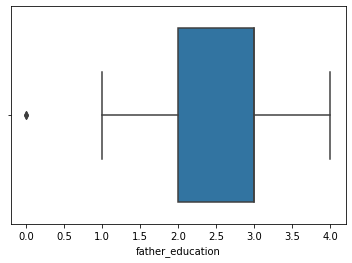

In [262]:
sns.boxplot('father_education',  data = students)
main_stat(students.mother_education)

Только у полпроцента учеников отец не имеет даже начального образования. Это настолько мало, что мы вполне можем удалить данный выброс:

In [263]:
students = students.loc[students.father_education > 0]

##  mother_job — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [264]:
display(pd.DataFrame(students.mother_job.value_counts(dropna=False, normalize=True)))

,mother_job
other,0.326816
services,0.245810
at_home,0.159218
teacher,0.131285
health,0.083799
NaN,0.053073


Около 5% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно)

## father_job — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [265]:
display(pd.DataFrame(students.father_job.value_counts(dropna=False, normalize=True)))

,father_job
other,0.508380
services,0.248603
NaN,0.094972
teacher,0.072626
at_home,0.039106
health,0.036313


Около 9% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно)

## school_choice_reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [266]:
display(pd.DataFrame(students.school_choice_reason.value_counts(dropna=False, normalize=True)))

,school_choice_reason
course,0.337989
reputation,0.270950
home,0.259777
other,0.086592
NaN,0.044693


Около 4% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно)

## guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [267]:
display(pd.DataFrame(students.guardian.value_counts(dropna=False, normalize=True)))

,guardian
mother,0.645251
father,0.220670
NaN,0.075419
other,0.058659


Около 8% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно)

## travel_time — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [268]:
display(pd.DataFrame(students.travel_time.value_counts(dropna=False, normalize=True)))

,travel_time
1.0,0.608939
2.0,0.243017
NaN,0.069832
3.0,0.058659
4.0,0.019553


Около 7% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Проверим выбросы:

 1-ый квартиль: 1.0, 3-ий квартиль: 2.0, IQR: 1.0. Границы выбросов: [-0.5, 3.5]


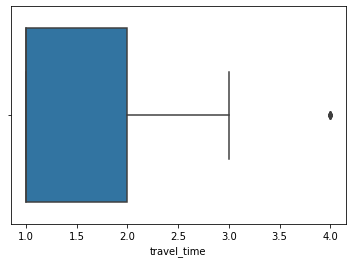

In [269]:
sns.boxplot('travel_time',  data = students)
main_stat(students.travel_time)

Хоть мы и наблюдаем наличие выброса, число школьников, добирающихся на занятия более часа, составляет 2%, что, пожалуй, нельзя назвать ничтожно малым, поэтому выброс не удаляем.

## study_time — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [270]:
display(pd.DataFrame(students.study_time.value_counts(dropna=False, normalize=True)))

,study_time
2.0,0.488827
1.0,0.265363
3.0,0.159218
4.0,0.067039
NaN,0.019553


Около 2% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Проверим выбросы:

 1-ый квартиль: 1.0, 3-ий квартиль: 2.0, IQR: 1.0. Границы выбросов: [-0.5, 3.5]


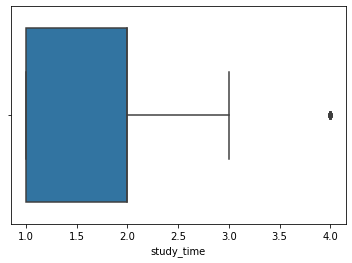

In [271]:
sns.boxplot('study_time',  data = students)
main_stat(students.study_time)

Аналогично предыдущему пункту, хоть мы и наблюдаем наличие выброса, число школьников, которые тратят на занятия свыше 10 часов, целых 7%, что не является ничтожно малым, поэтому выброс не удаляем. Также нельзя не заметить, что графики travel_time и study_time очень похожи. Возникает предположение, что между ними достаточно высокий коэффициент корреляции. Проверим нашу гипотезу:

In [272]:
print(students.study_time.corr(students['travel_time']))

-0.11541063576288352


Модуль коэффициента корреляции низкий, гипотеза не подтвердилась. Видимо, случайное совпадение

## non_study_failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

In [273]:
display(pd.DataFrame(students.non_study_failures.value_counts(dropna=False, normalize=True)))

,non_study_failures
0.0,0.762570
1.0,0.122905
NaN,0.050279
3.0,0.033520
2.0,0.030726


Около 5% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно, под внеучебной деятельностью может подразумеваться практически все, что угодно). Проверим выбросы:

 1-ый квартиль: 0.0, 3-ий квартиль: 0.0, IQR: 0.0. Границы выбросов: [0.0, 0.0]


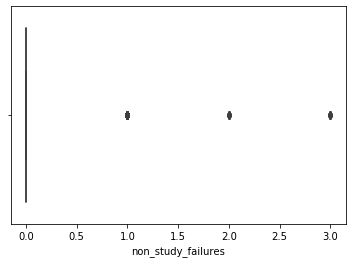

In [274]:
sns.boxplot('non_study_failures',  data = students)
main_stat(students.non_study_failures)

Поскольку более 75% школьников внеучебных неудач не имеют, то любое значение, отличное от 0, является выбросом. Однако удалять эти выбросы мы не будем, т.к. 3% и тем более 12% - это не ничтожно мало и может повлиять на общую статистику.

## school_educational_support — дополнительная образовательная поддержка (yes или no)

In [275]:
display(pd.DataFrame(students.school_educational_support.value_counts(dropna=False, normalize=True)))

,school_educational_support
no,0.851955
yes,0.125698
NaN,0.022346


Около 2% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). 

## family_educational_support — семейная образовательная поддержка (yes или no)

In [276]:
display(pd.DataFrame(students.family_educational_support.value_counts(dropna=False, normalize=True)))

,family_educational_support
yes,0.555866
no,0.349162
NaN,0.094972


Около 10% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

 ## maths_tutor— дополнительные платные занятия по математике (yes или no)

In [277]:
display(pd.DataFrame(students.maths_tutor.value_counts(dropna=False, normalize=True)))

,maths_tutor
no,0.508380
yes,0.391061
NaN,0.100559


Около 10% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

## extra_activities — дополнительные внеучебные занятия (yes или no)

In [278]:
display(pd.DataFrame(students.extra_activities.value_counts(dropna=False, normalize=True)))

,extra_activities
yes,0.488827
no,0.472067
NaN,0.039106


Около 4% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

## nursery — посещал детский сад (yes или no)

In [279]:
display(pd.DataFrame(students.nursery.value_counts(dropna=False, normalize=True)))

,nursery
yes,0.762570
no,0.195531
NaN,0.041899


Около 4% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

 ## want_higher_education — хочет получить высшее образование (yes или no)

In [280]:
display(pd.DataFrame(students.want_higher_education.value_counts(dropna=False, normalize=True)))

,want_higher_education
yes,0.907821
no,0.050279
NaN,0.041899


Около 4% данных в столбце пропущены. Однако здесь мы видим явный перекос в сторону утвердительного ответа, поэтому можем заполнить пропуски значением "yes"

In [281]:
students.want_higher_education = students.want_higher_education.fillna("yes")
students.loc[:, ['want_higher_education']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 394
Data columns (total 1 columns):
want_higher_education    358 non-null object
dtypes: object(1)
memory usage: 5.6+ KB


## internet — наличие интернета дома (yes или no)

In [282]:
display(pd.DataFrame(students.internet.value_counts(dropna=False, normalize=True)))

,internet
yes,0.768156
no,0.139665
NaN,0.092179


Около 10% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

In [283]:
nominative_features.append('internet')

## romantic — в романтических отношениях (yes или no)

In [284]:
display(pd.DataFrame(students.romantic.value_counts(dropna=False, normalize=True)))

,romantic
no,0.608939
yes,0.312849
NaN,0.078212


Около 8% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

## family_relations — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [285]:
display(pd.DataFrame(students.family_relations.value_counts(dropna=False, normalize=True)))

,family_relations
4.0,0.455307
5.0,0.248603
3.0,0.162011
NaN,0.067039
2.0,0.044693
1.0,0.019553
-1.0,0.002793


Около 7% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Значение -1, скорее всего, опечатка, исправим ее:

In [286]:
students.family_relations = students.family_relations.apply(lambda x: float(str(x).replace('-1', '1')))

Проверим выбросы:

 1-ый квартиль: 4.0, 3-ий квартиль: 5.0, IQR: 1.0. Границы выбросов: [2.5, 6.5]


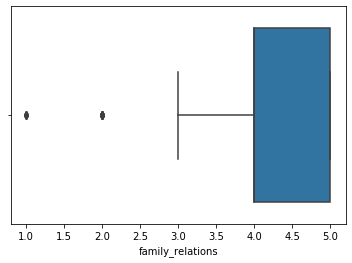

In [287]:
sns.boxplot('family_relations',  data = students)
main_stat(students.family_relations)

Как видим, большинство школьников имеют хорошие и нормальные взаимоотношения с родителями (от 3 до 5 по пятибалльной школе). Однако значения 1 и 2, которые на общем фоне являются выбросами, мы все же удалять не будем, т.к. показатели 6% школьников лежат в этом диапозоне (1 - 2%, 2 - 4% соответственно). 

## freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [288]:
display(pd.DataFrame(students.freetime.value_counts(dropna=False, normalize=True)))

,freetime
3.0,0.399441
4.0,0.276536
2.0,0.167598
5.0,0.086592
1.0,0.050279
NaN,0.019553


Около 2% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Проверим выбросы:

 1-ый квартиль: 3.0, 3-ий квартиль: 4.0, IQR: 1.0. Границы выбросов: [1.5, 5.5]


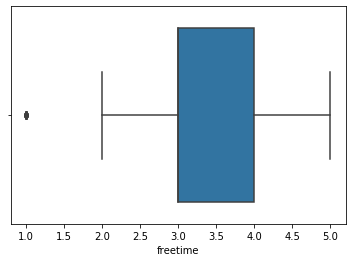

In [289]:
sns.boxplot('freetime',  data = students)
main_stat(students.freetime)

5% - это не ничтожно мало, выбросы оставляем.

## goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [290]:
display(pd.DataFrame(students.goout.value_counts(dropna=False, normalize=True)))

,goout
3.0,0.326816
2.0,0.256983
4.0,0.206704
5.0,0.128492
1.0,0.061453
NaN,0.019553


Около 2% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Посмотрим, как скоррелированы между собой столбцы "freetime" и "goout":

In [291]:
print(students.freetime.corr(students['goout']))

0.28516660265277205


Коэффициент корреляции достаточно низкий, только 0.28. Значит, если у школьников появляется свободное время, то они, как правило, не тратят большую его часть на общение с друзьями. Возможно, оно уходит на посещение кружков, саморазвитие, а также отдых отдельно от компанииь (компьютерные игры, чтение и пр.)

Проверим выбросы:


 1-ый квартиль: 2.0, 3-ий квартиль: 4.0, IQR: 2.0. Границы выбросов: [-1.0, 7.0]


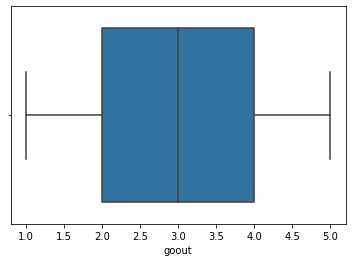

In [292]:
sns.boxplot('goout',  data = students)
main_stat(students.goout)

Выбросов здесь нет.

## health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [293]:
display(pd.DataFrame(students.health.value_counts(dropna=False, normalize=True)))

,health
5.0,0.346369
3.0,0.220670
4.0,0.162011
1.0,0.122905
2.0,0.111732
NaN,0.036313


Около 4% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Проверим выбросы:

 1-ый квартиль: 3.0, 3-ий квартиль: 5.0, IQR: 2.0. Границы выбросов: [0.0, 8.0]


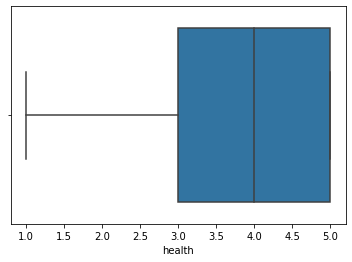

In [294]:
sns.boxplot('health',  data = students)
main_stat(students.health)

Выбросов здесь нет.

 ## absences — количество пропущенных занятий

In [295]:
display(pd.DataFrame(students.absences.value_counts(dropna=False, normalize=True)))

,absences
0.0,0.287709
2.0,0.156425
4.0,0.131285
6.0,0.078212
8.0,0.053073
10.0,0.041899
NaN,0.030726
14.0,0.030726
12.0,0.030726
3.0,0.016760


Около 3% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Проверим выбросы:

 1-ый квартиль: 0.0, 3-ий квартиль: 8.0, IQR: 8.0. Границы выбросов: [-12.0, 20.0]


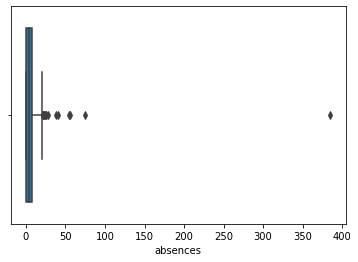

In [296]:
sns.boxplot('absences',  data = students)
main_stat(students.absences)

Несмотря на статистику, здравый смысл говорит, что 20 дней - это слишком мало для любителей прогулять школу (по сравнению с общим количеством учебных дней в году). Поэтому удалим только выброс 385, поставив верхнюю границу в 75 пропусков:

In [297]:
students = students.loc[students.absences <= 75]

## score — баллы по госэкзамену по математике

Посмотрим на столбец "score" - собственно, тот, который нашей модели и нужно будет предсказать:

In [298]:
display(pd.DataFrame(students.score.value_counts(dropna=False, normalize=True)))

,score
50.0,0.147399
55.0,0.124277
0.0,0.095376
65.0,0.083815
70.0,0.078035
75.0,0.078035
60.0,0.078035
40.0,0.075145
45.0,0.066474
80.0,0.043353


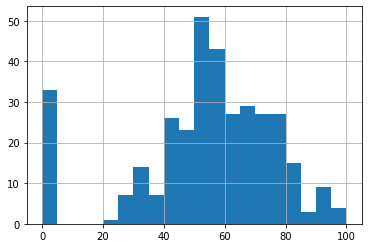

In [299]:
students.score.hist(bins=20)

График полностью соответствует ожиданиям: примерно так чаще всего и выглядит распределение оценок за экзамен. Основная масса сдала средне, получив результат в районе 50-60 баллов, еще достаточно большая группа людей написала хорошо (60-80) и лишь немногие получили очень низкие (менее 40 баллов) и очень высокие (80+) результаты. Здравый смысл говорит, что люди, получившие 0 за экзамен, - это, скорее всего, те, кто на него не пришел, поэтому удалим их из общей статистики:

In [300]:
students = students.loc[students.score > 0]

# Корреляционный анализ

Для начала оценим, какие номинативные переменные сильнее всего влияют на успешность сдачи экзамена, проведя корреляционный анализ:

In [301]:
students.corr()

,age,mother_education,father_education,travel_time,study_time,non_study_failures,family_relations,freetime,goout,health,absences,score
age,1.000000,-0.126705,-0.109119,0.119288,0.043711,0.123861,-0.009353,-0.081216,0.086300,-0.022339,0.222806,-0.159133
mother_education,-0.126705,1.000000,0.629931,-0.195075,0.055843,-0.214472,-0.007129,-0.002355,0.050350,-0.060966,0.060723,0.199358
father_education,-0.109119,0.629931,1.000000,-0.141287,-0.019705,-0.251198,-0.004529,-0.013156,0.033231,-0.010474,0.030266,0.133737
travel_time,0.119288,-0.195075,-0.141287,1.000000,-0.118338,0.105026,-0.034655,-0.008474,0.019632,0.030389,-0.012731,-0.087719
study_time,0.043711,0.055843,-0.019705,-0.118338,1.000000,-0.127768,0.075817,-0.117961,-0.017262,-0.077547,-0.061585,0.153930
non_study_failures,0.123861,-0.214472,-0.251198,0.105026,-0.127768,1.000000,-0.059749,0.070280,0.093331,0.107642,0.134673,-0.281472
family_relations,-0.009353,-0.007129,-0.004529,-0.034655,0.075817,-0.059749,1.000000,0.137957,0.038476,0.111386,-0.053438,0.056762
freetime,-0.081216,-0.002355,-0.013156,-0.008474,-0.117961,0.070280,0.137957,1.000000,0.275081,0.075569,-0.095026,-0.013106
goout,0.086300,0.050350,0.033231,0.019632,-0.017262,0.093331,0.038476,0.275081,1.000000,0.032454,0.011255,-0.199217
health,-0.022339,-0.060966,-0.010474,0.030389,-0.077547,0.107642,0.111386,0.075569,0.032454,1.000000,-0.007151,-0.067135


Видим, что все количественные переменные так или иначе скоррелированы c итоговой оценкой за экзамен, при этом наибольшее влияние на оценку оказывает количество внеучебных неудач (столбец "non_study_failures"), что, в принципе, объяснимо, т.к. проблемы в личной жизни часто мешают нам сосредоточиться на делах. Наименьшее влияние оказало наличие свободного времени, что тоже вполне логично, т.к. под свободным временем мы подразумеваем время, когда школьник не занят учебой.

Для более полной картины применим теперь дополнительный статистический метод, позволяющий, позволяющий найти статистически значимые различия как для количественных, так и для номинативных переменных:

In [302]:
for column in students.columns:
    get_stat_dif(column)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mother_education
Найдены статистически значимые различия для колонки mother_job
Найдены статистически значимые различия для колонки study_time
Найдены статистически значимые различия для колонки non_study_failures
Найдены статистически значимые различия для колонки school_educational_support
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки score


Итак, важными переменными, оказывающими наиболее существенное влияние на экзамен, являются sex, address, mother_education, mother_job, study_time, non_study_failres, school_educational_support и goout. Здравый смысл также говорит, что сюда стоит добавить:  
  
1) father_job и father_education (логично учитывать образование и работу обоих родителей);  
2) absences (безусловно, количество пропусков влияет на учебу, да и коэффициент корреляции, судя по предыдущей таблице, достаточно высок);  
3) maths_tutor (дополнительные занятия по математике помогают улучшить успеваемость и "натаскаться" непосредственно на экзамен);  

Используем их для построения модели:

In [303]:
for_model = students.loc[:, ["sex", "address", "mother_education", "mother_job", "father_education", "father_job", 
                              "maths_tutor", "study_time", "non_study_failures", "school_educational_support", "goout", "absences"]]

# Выводы

1) В данных довольно много пропусков (в среднем от 5 до 10% на каждый столбец), которые в большинстве случаев заполнить невозможно, а, удалив их, мы потеряем примерно половину информации из датасета.  
2) Многие количественные переменные имеют выбросы, однако удалять их чаще всего не нужно, т.к. на практике эти значения встречаются пусть и реже, чем остальные, но все же их вероятность не стремится к 0.  
3) Наиболее значимые столбцы, которые нам пригодятся в дальнейшем при построении модели: "sex", "address", "mother_education", "mother_job", "father_education", "father_job", "maths_tutor", "study_time", "non_study_failures", "school_educational_support", "goout", "absences".